In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D , MaxPooling2D , Flatten , Dropout , BatchNormalization, Concatenate, GlobalAveragePooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3


In [5]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 224

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))     # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing image: {os.path.join(path, img)}")
                print(e)
    return data

In [6]:
train = get_data('C:/project/6th sem/archive/chest_xray/chest_xray/train')
test = get_data('C:/project/6th sem/archive/chest_xray/chest_xray/test')
val = get_data('C:/project/6th sem/archive/chest_xray/chest_xray/val')

Error processing image: C:/project/6th sem/archive/chest_xray/chest_xray/train\PNEUMONIA\.DS_Store
OpenCV(4.7.0) C:\Users\tanya\AppData\Local\Temp\pip-install-mc7g7t8y\opencv-python_af8f37a967cd4cee964385cf9bf1d203\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error processing image: C:/project/6th sem/archive/chest_xray/chest_xray/train\NORMAL\.DS_Store
OpenCV(4.7.0) C:\Users\tanya\AppData\Local\Temp\pip-install-mc7g7t8y\opencv-python_af8f37a967cd4cee964385cf9bf1d203\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error processing image: C:/project/6th sem/archive/chest_xray/chest_xray/val\PNEUMONIA\.DS_Store
OpenCV(4.7.0) C:\Users\tanya\AppData\Local\Temp\pip-install-mc7g7t8y\opencv-python_af8f37a967cd4cee964385cf9bf1d203\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

Error proces

In [7]:
pneumonia = os.listdir("C:/project/6th sem/archive/chest_xray/train/PNEUMONIA")
pneumonia_dir = "C:/project/6th sem/archive/chest_xray/train/PNEUMONIA"

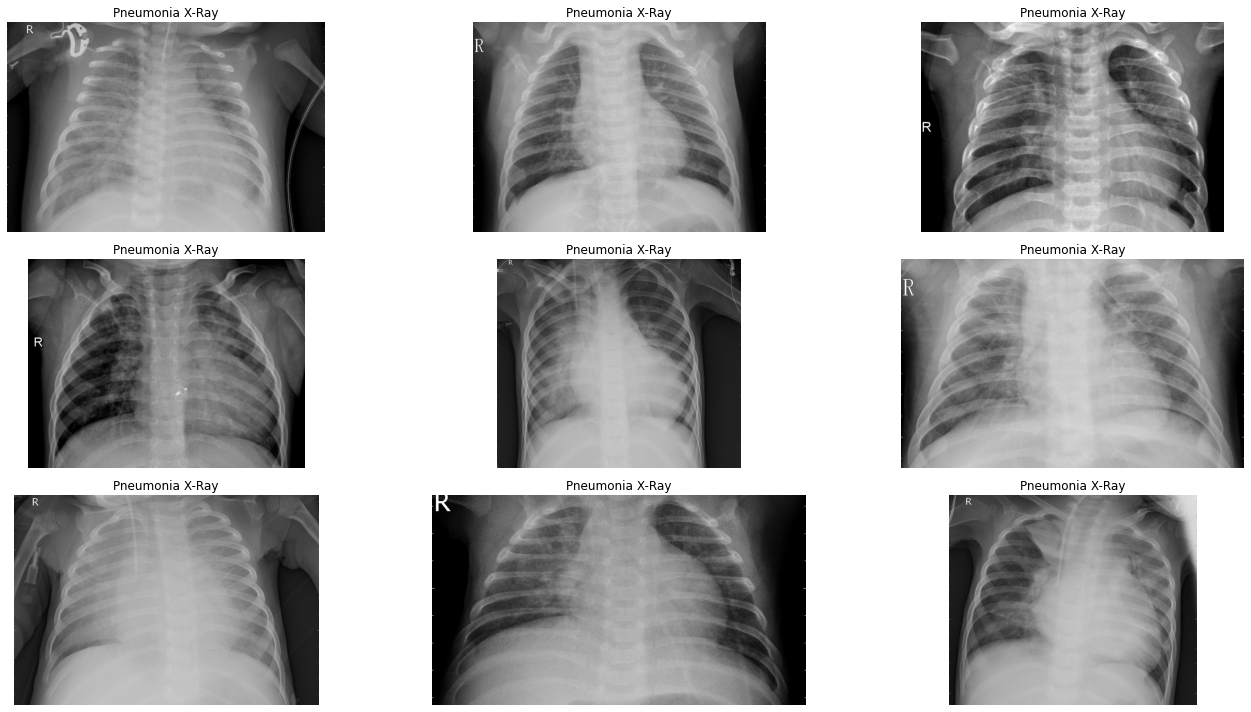

In [8]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(pneumonia_dir, pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Pneumonia X-Ray")
plt.tight_layout()

File not found: C:/project/6th sem/chest_xray/train/NORMAL\IM-0115-0001.jpeg
File not found: C:/project/6th sem/chest_xray/train/NORMAL\IM-0117-0001.jpeg
File not found: C:/project/6th sem/chest_xray/train/NORMAL\IM-0119-0001.jpeg
File not found: C:/project/6th sem/chest_xray/train/NORMAL\IM-0122-0001.jpeg
File not found: C:/project/6th sem/chest_xray/train/NORMAL\IM-0125-0001.jpeg
File not found: C:/project/6th sem/chest_xray/train/NORMAL\IM-0127-0001.jpeg
File not found: C:/project/6th sem/chest_xray/train/NORMAL\IM-0128-0001.jpeg
File not found: C:/project/6th sem/chest_xray/train/NORMAL\IM-0129-0001.jpeg
File not found: C:/project/6th sem/chest_xray/train/NORMAL\IM-0131-0001.jpeg


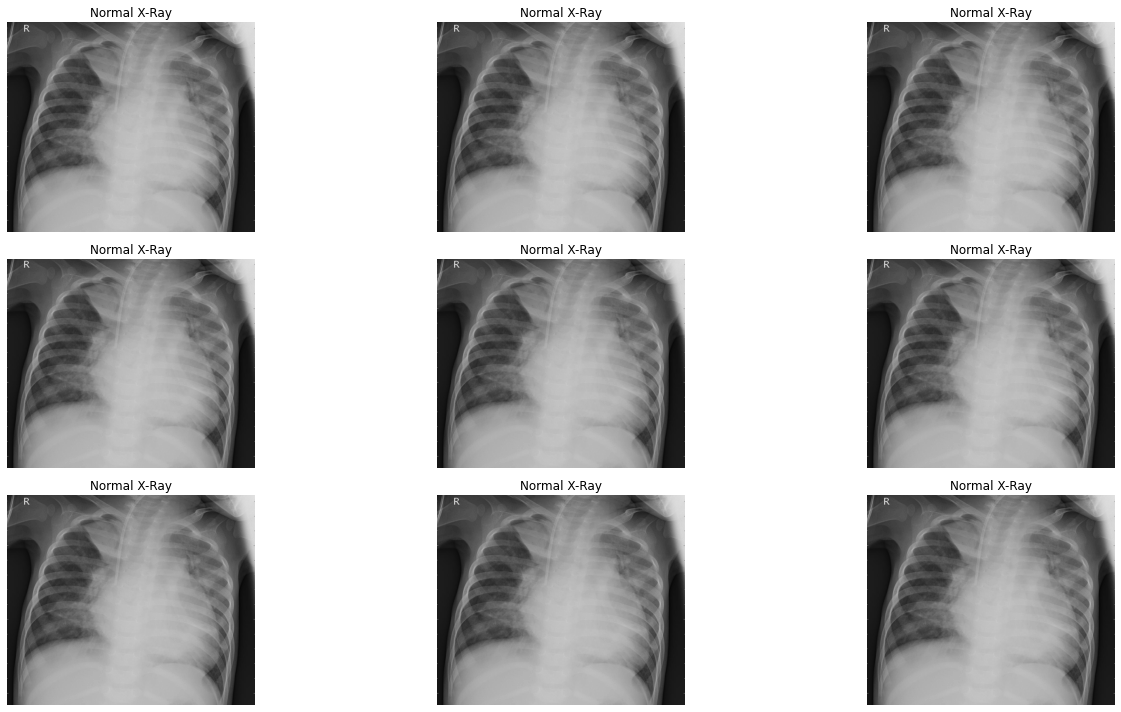

In [12]:
normal = os.listdir("C:/project/6th sem/archive/chest_xray/train/NORMAL")
normal_dir = "C:/project/6th sem/chest_xray/train/NORMAL"

plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    try:
        img = plt.imread(os.path.join(normal_dir, normal[i]))
    except FileNotFoundError:
        print(f"File not found: {os.path.join(normal_dir, normal[i])}")
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Normal X-Ray")

plt.tight_layout()

<AxesSubplot:ylabel='count'>

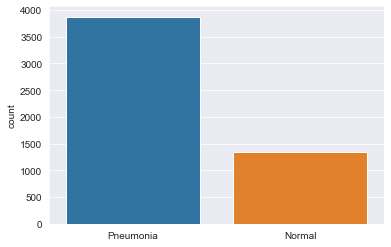

In [13]:
list = []
for i in train:
    if(i[1] == 0):
        list.append("Pneumonia")
    else:
        list.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=list)

In [14]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [15]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [16]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(x_train)

In [17]:
def inception_module(x, filters):
    f1, f3, f5 = filters
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    conv3 = Conv2D(f3, (3,3), padding='same', activation='relu')(x)
    conv5 = Conv2D(f5, (5,5), padding='same', activation='relu')(x)
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    conv_pool = Conv2D(f1, (1,1), padding='same', activation='relu')(pool)
    return Concatenate()([conv1, conv3, conv5, conv_pool])

input = Input(shape=(224, 224, 1))
x = Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(input)
x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (1,1), padding='same', activation='relu')(x)
x = Conv2D(192, (3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
x = inception_module(x, [64, 96, 128])
x = inception_module(x, [128, 128, 192])
x = MaxPooling2D((3,3), strides=(2,2), padding='same')(x)
x = inception_module(x, [192, 256, 256])
x = inception_module(x, [192, 256, 256])
x = inception_module(x, [256, 256, 384])
x = AveragePooling2D((7,7), strides=(1,1), padding='valid')(x)
x = Dropout(0.4)(x)
x = Flatten()(x)
output = Dense(units=1, activation='sigmoid')(x)
model = Model(inputs=input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 3200        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 56, 56, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [18]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [19]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 122s 575ms/step - loss: 9.4806 - accuracy: 0.8062 - val_loss: 2.1844 - val_accuracy: 0.5000
Epoch 2/12
163/163 [==============================] - 87s 532ms/step - loss: 0.2395 - accuracy: 0.9003 - val_loss: 1.7268 - val_accuracy: 0.5000
Epoch 3/12
163/163 [==============================] - 87s 533ms/step - loss: 0.1635 - accuracy: 0.9365 - val_loss: 2.9823 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/12
163/163 [==============================] - 87s 533ms/step - loss: 0.1203 - accuracy: 0.9544 - val_loss: 0.4411 - val_accuracy: 0.8125
Epoch 5/12
163/163 [==============================] - 87s 532ms/step - loss: 0.1230 - accuracy: 0.9507 - val_loss: 0.4623 - val_accuracy: 0.8125
Epoch 6/12
163/163 [==============================] - 87s 533ms/step - loss: 0.1067 - accuracy: 0.9574 - val_loss: 0.6231 - val_accuracy: 0.7500

Epoch 00006: ReduceLROnPlateau reducing learnin

In [20]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 4s 172ms/step - loss: 0.3915 - accuracy: 0.8526
Loss of the model is -  0.3915228843688965
20/20 [==============================] - 3s 171ms/step - loss: 0.3915 - accuracy: 0.8526
Accuracy of the model is -  85.25640964508057 %
